# CWT & STFT + CNN Model with Unicorn Hybrid Black dataset

In [170]:
import mne
import numpy as np
from mne.datasets import eegbci
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage


raw_each = [0] * 10
for i in range(0,10):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws([raw_each[0],raw_each[1],raw_each[2],raw_each[4],raw_each[5],raw_each[6]])
# raw_edf = mne.concatenate_raws([raw_each[0],raw_each[1],raw_each[4],raw_each[3]])
# raw_edf = mne.concatenate_raws([raw_each[2],raw_each[5],raw_each[6],raw_each[7]])
raw_edf = mne.concatenate_raws([raw_each[9]])

# raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\MI_execution.edf", preload=True)

eegbci.standardize(raw_edf)  # set channel names
montage = make_standard_montage("standard_1005")
raw_edf.set_montage(montage)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_n

<RawEDF | hand9_new.edf, 8 x 279250 (1117.0 s), ~17.1 MB, data loaded>

In [171]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Activation, Dropout,LSTM,Reshape
from keras.models import Sequential
from keras.callbacks import History,ModelCheckpoint
from keras.utils import plot_model
history = History()
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mne.decoding import CSP
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit,StratifiedKFold ,cross_val_score, cross_val_predict
from ssqueezepy import ssq_cwt, ssq_stft
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [172]:
# eeg1 = raw_edf.copy().set_eeg_reference(ref_channels="average")
# eeg1= eeg1.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','PO8'])

eeg1= raw_edf.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','Oz','PO8'])

events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin= -1.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 3.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(-0.2, 0)
    )
combine_epochs = combine_epochs.copy().crop(tmin=0.0, tmax=1.0)
# combine_epochs = combine_epochs.copy().filter(l_freq=6.0, h_freq=32.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

nonim_epochs2 = mne.Epochs(eeg1, events, 
        tmin= -3.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 1.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop',
        baseline=(-2.2, 0)
    )
nonim_epochs2 = nonim_epochs2.copy().crop(tmin=-1.0, tmax=0.0)
# nonim_epochs2 = nonim_epochs2.copy().filter(l_freq=6.0, h_freq=32.0, method = 'iir', iir_params= {"order": 6, "ftype":'butter'})

component_num = 8

Used Annotations descriptions: ['OVTK_GDF_Cross_On_Screen', 'OVTK_GDF_End_Of_Session', 'OVTK_GDF_End_Of_Trial', 'OVTK_GDF_Feedback_Continuous', 'OVTK_GDF_Left', 'OVTK_GDF_Right', 'OVTK_GDF_Start_Of_Trial', 'OVTK_GDF_Tongue', 'OVTK_GDF_Up', 'OVTK_StimulationId_BaselineStart', 'OVTK_StimulationId_BaselineStop', 'OVTK_StimulationId_Beep', 'OVTK_StimulationId_ExperimentStart', 'OVTK_StimulationId_Train']
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
608 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 608 events and 1001 original time points ...
2 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
608 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 608 events and

1 bad epochs dropped


In [173]:
combine_epochs

Number of events,606
Events,OVTK_GDF_Cross_On_Screen: 3OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_BaselineStop: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 0
Time range,0.000 – 1.000 s
Baseline,-0.200 – 0.000 s


In [174]:
nonim_epochs2

Number of events,607
Events,OVTK_GDF_Cross_On_Screen: 3OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_BaselineStop: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 1
Time range,-1.000 – 0.000 s
Baseline,-2.200 – 0.000 s


In [175]:
combine_epochs.event_id

{'OVTK_GDF_Cross_On_Screen': 1,
 'OVTK_GDF_End_Of_Session': 2,
 'OVTK_GDF_End_Of_Trial': 3,
 'OVTK_GDF_Feedback_Continuous': 4,
 'OVTK_GDF_Left': 5,
 'OVTK_GDF_Right': 6,
 'OVTK_GDF_Start_Of_Trial': 7,
 'OVTK_GDF_Tongue': 8,
 'OVTK_GDF_Up': 9,
 'OVTK_StimulationId_BaselineStart': 10,
 'OVTK_StimulationId_BaselineStop': 11,
 'OVTK_StimulationId_Beep': 12,
 'OVTK_StimulationId_ExperimentStart': 13,
 'OVTK_StimulationId_Train': 14}

# CSP -> CWT -> CNN

In [176]:
class_left = combine_epochs.event_id['OVTK_GDF_Left']
class_right = combine_epochs.event_id['OVTK_GDF_Right']
class_non = combine_epochs.event_id['OVTK_GDF_Tongue']
class_up = combine_epochs.event_id['OVTK_GDF_Up']

select_classes = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Tongue','OVTK_GDF_Up']

#######################################################
labels = select_classes.events[:,2]
for i in range(0,len(labels)):
    if labels[i] == class_left:
        labels[i] = 1
    elif labels[i] == class_right:
        labels[i] = 1
    elif labels[i] == class_non:
        labels[i] = 2
    else:
        labels[i] = 1
        
train_data1 = select_classes.get_data()
train_data2 = nonim_epochs2['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
train_data = np.concatenate((train_data1, train_data2), axis=0)
# train_data = train_data1


labels = np.concatenate((labels,np.full((train_data2.shape[0],), 2)), axis = 0)

In [177]:
train_data.shape

(240, 8, 251)

In [178]:
labels

array([2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

try csp+lda trined model

In [179]:
# csp2 = CSP(n_components=component_num, reg=None, log=None)
# csp2.fit(train_data, labels)
# with open('trained_csp2_model.pkl', 'wb') as file:
#     pickle.dump(csp2, file)

with open('trained_csp2_model.pkl', 'rb') as file:
    trained_csp2 = pickle.load(file)
new_data2 = trained_csp2.transform(train_data)

# lda2 = LinearDiscriminantAnalysis()
# lda2.fit(new_data2, labels)
# with open('trained_lda_model.pkl', 'wb') as file:
#     pickle.dump(lda2, file)

with open('trained_lda_model.pkl', 'rb') as file:
    trained_lda = pickle.load(file)

    
score = cross_val_score(trained_lda,new_data2, labels, cv= 10)
lda_predicted = cross_val_predict(trained_lda, new_data2, labels, cv=10)
conf_matrix = confusion_matrix(labels, lda_predicted)
print("LDA only classification scores", score, np.mean(score))
print(conf_matrix)

score = trained_lda.score(new_data2, labels)
lda_predicted = trained_lda.predict(new_data2)
conf_matrix = confusion_matrix(labels, lda_predicted)
print("LDA only classification scores", score)
print(conf_matrix)


LDA only classification scores [0.91666667 0.95833333 1.         0.75       0.91666667 0.875
 0.79166667 0.91666667 0.83333333 1.        ] 0.8958333333333333
[[ 75  15]
 [ 10 140]]
LDA only classification scores 0.7083333333333334
[[ 20  70]
 [  0 150]]


Try FBCSP

In [180]:
# low_fre = [6, 10, 14, 18, 22, 26]
# high_fre = [12, 16, 20, 24, 28, 32]

# shape = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data().shape

# train_data = np.ndarray(shape= (6,shape[0],shape[1],shape[2]))

# FB_data = np.ndarray(shape= (6,shape[0],shape[1],shape[2]))
# # FB_data = np.ndarray(shape= (6,shape[0],shape[1]))


# for i in range(0,6):
#     combine_epochs = combine_epochs.filter(l_freq=low_fre[i], h_freq=high_fre[i], method = 'iir', iir_params= {"order": 5, "ftype":'butter'}, verbose = False)
#     train_data[i] = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
    
#     csp = CSP(n_components=component_num, reg=None, log=None, transform_into='csp_space')
#     # csp = CSP(n_components=component_num, reg=None, log=None)
#     csp.fit(train_data[i], labels)

#     with open('trained_FBCSP_model'+str(i)+'.pkl', 'wb') as file:
#         pickle.dump(csp, file)

# for j in range(0,6):
#     with open('trained_FBCSP_model'+str(j)+'.pkl', 'rb') as file:
#         trained_csp = pickle.load(file)

#     FB_data[j] = trained_csp.transform(train_data[j])

# FB_data = np.concatenate(FB_data, axis = 1)

In [181]:
# lda3 = LinearDiscriminantAnalysis()
# lda3.fit(FB_data, labels)
# with open('trained_lda3_model.pkl', 'wb') as file:
#     pickle.dump(lda3, file)

# with open('trained_lda3_model.pkl', 'rb') as file:
#     trained_lda3 = pickle.load(file)


# score = cross_val_score(trained_lda3, FB_data, labels, cv= 15)
# lda_predicted = cross_val_predict(trained_lda3, FB_data, labels, cv= 15)
# conf_matrix = confusion_matrix(labels, lda_predicted)
# print("LDA only classification scores", score, np.mean(score))
# print(conf_matrix)

# score = trained_lda3.score(FB_data, labels)
# lda_predicted = trained_lda3.predict(FB_data)
# conf_matrix = confusion_matrix(labels, lda_predicted)
# print("LDA only classification scores", score)
# print(conf_matrix)

train csp

In [182]:
# csp = CSP(n_components=component_num, reg=None, log=None, transform_into='csp_space')
# csp.fit(train_data, labels)

# with open('trained_csp_newsess_nonvsim_model.pkl', 'wb') as file:
#     pickle.dump(csp, file)

load csp

In [183]:
with open('trained_csp_newsess_nonvsim_model.pkl', 'rb') as file:
    trained_csp = pickle.load(file)

new_data = trained_csp.transform(train_data)
print(new_data.shape)

(240, 8, 251)


FFT

In [184]:
# channels2 = ["Fz","C3", "Cz", "C4","Pz","PO7","Oz","PO8"]

# info2 = mne.create_info(
#     ch_names= channels2,
#     ch_types= ['eeg']*len(channels2),
#     sfreq= 250
# )
# FFT_epoch = mne.EpochsArray(new_data, info2, verbose=False)


# FFT_data=  FFT_epoch.compute_psd(fmax = 32).get_data()

CWT

In [185]:
FB = 1
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], component_num*FB))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(train_cwt))

scales = range(1,31)

waveletname = 'morl'
train_size = len(labels)
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], component_num*FB))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,component_num*FB):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]] 
        train_data_cwt[ii, :, :, jj] = coeff_
print(np.shape(train_data_cwt))

train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*component_num*FB, new_data.shape[2]))

# train_cwt_stack = np.ndarray(shape=(train_size , new_data.shape[2], len(scales)*component_num*FB))

for jj in range(0,train_data_cwt.shape[0]):
    # train_cwt_stack[jj] = np.concatenate(train_data_cwt[jj], axis = 1)
    
    train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6], train_data_cwt[jj,:,:,7]))
    # train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2]))
print(np.shape(train_cwt_stack))

(240, 251, 8)
0


40
80
120
160
200
(240, 30, 251, 8)
(240, 240, 251)


Try scaler

In [186]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# reshaped_data = train_cwt_stack.reshape((train_cwt_stack.shape[0], -1))
# scaled_data = scaler.fit_transform(reshaped_data)
# scaled_data_3d = scaled_data.reshape(train_cwt_stack.shape)
# print(scaled_data_3d.shape)

In [187]:
# train_cwt_stack = new_data
x_train, x_test, y_train, y_test = train_test_split(train_cwt_stack, labels, test_size=0.3, random_state=42)

num_classes = len(np.unique(labels))
lowest = np.min(y_train)
batch_size = 1
epochs = 15
print(np.shape(x_train), np.shape(x_test), np.shape(y_train), np.shape(y_test))

y_train = keras.utils.to_categorical(y_train-lowest, num_classes)
y_test = keras.utils.to_categorical(y_test-lowest, num_classes)

(168, 240, 251) (72, 240, 251) (168,) (72,)


# Purposed CNN Model

In [188]:
# # Define the CNN model
# model = Sequential()

# # Convolutional Layer 1 with 32 filters of kernel size 3x3
# model.add(Conv2D(32, (3, 3), input_shape=(train_cwt_stack.shape[1], train_cwt_stack.shape[2],1), activation='relu'))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Convolutional Layer 2 with 64 filters of kernel size 3x3
# model.add(Conv2D(64, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5)) 

# # Max-Pooling Layer 2 with pool size 2x2
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # model.add(Reshape(target_shape=(4, 497*64)))

# # model.add(LSTM(50, activation='relu'))

# # Flatten the output from the previous layer
# model.add(Flatten())

# # Output Layer with the desired number of output nodes (adjust as needed)
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy, 
#               optimizer=keras.optimizers.Adam(learning_rate= 0.0001), 
#               metrics=['accuracy'])

# model.summary()
# plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# checkpoint = ModelCheckpoint("CNN_model_newsess_nonvsim_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# model.fit(x_train, y_train, batch_size=batch_size, 
#           epochs=epochs, verbose=1, 
#           validation_data=(x_test, y_test), 
#           callbacks=[history, checkpoint])

In [189]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# # Define the model
# model = Sequential()

# # Add an LSTM layer with 50 units (you can adjust this as needed) and input shape (8, 501)
# model.add(LSTM(50, input_shape=(8, 501)))

# # Add a dense layer with output dimension 1 (for example, for binary classification)
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy, 
#               optimizer=keras.optimizers.Adam(learning_rate= 0.001), 
#               metrics=['accuracy'])

# model.summary()
# plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# checkpoint = ModelCheckpoint("RNN_model_newness_nonvsim_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# model.fit(x_train, y_train, batch_size=batch_size, 
#           epochs=epochs, verbose=1, 
#           validation_data=(x_test, y_test), 
#           callbacks=[history, checkpoint])


8/8 [==============================] - 1s 147ms/step


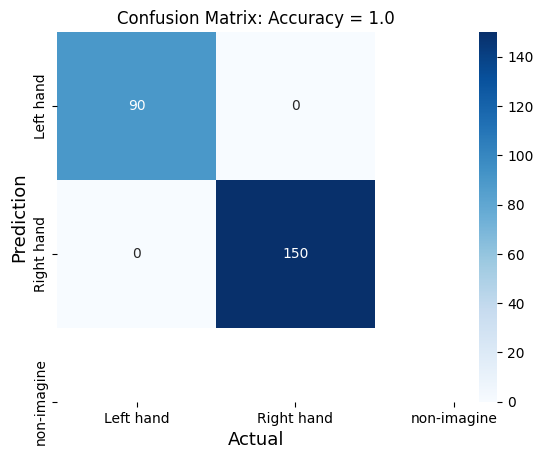

In [190]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
pretrained_model = load_model("CNN_model_newsess_nonvsim_weights.h5")

y_test = keras.utils.to_categorical(labels-lowest, num_classes)

loss, accuracy = pretrained_model.evaluate(train_cwt_stack, y_test)

y_pred = pretrained_model.predict(train_cwt_stack)
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_test, axis=1)

confusion_mat = confusion_matrix(y_true, y_pred)

# class_names = ['Left hand', 'Right hand',  'Non-imagine', 'Feet']

# class_names = ['Right hand','Non-imagine']

# class_names = ['Imagine','Non-imagine']

class_names = ['Left hand', 'Right hand', 'non-imagine']

# class_names = ['Left hand', 'Right hand', 'Up']

sns.heatmap(confusion_mat, 
            annot=True,
            fmt='d', 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Confusion Matrix: Accuracy = "+ str(round(accuracy,3)))
plt.show()